# Hard spheres model demo on MNIST data

## Imports

In [2]:
# Basic
from IPython.display import display

# For OS-agnostic paths
from pathlib import Path

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch import nn
import pandas as pd
import numpy as np
sns.set_style("whitegrid")
from copy import deepcopy
import glob, json
from datetime import datetime
import torch
from torch import nn

from torch.utils.data import DataLoader, Dataset

from torchinfo import summary

import mlflow

## Load data TODO

In [3]:
# Load MNIST

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

def load_mnist():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    target_transform = transforms.Compose([
        transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32))
    ])

    trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform, target_transform=target_transform)
    testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform, target_transform=target_transform)
    
    return trainset, testset

trainset, testset = load_mnist()

In [4]:
trainset[0][0].shape

torch.Size([1, 28, 28])

## Mock data

Make the digit (label) the input based on which the gan generates data.

The goal is to train the gan to generate images of the digit that is fed as the input.

In [5]:
# Make the digit (label) the input based on which the gan generates data.

# The goal is to train the gan to generate images of the digit that is fed as the input.

class MNISTLabelDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return label, image
    
trainset = MNISTLabelDataset(trainset)
testset = MNISTLabelDataset(testset)

In [369]:
trainset[0]

(tensor(5.),
 tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1

tensor(5.)


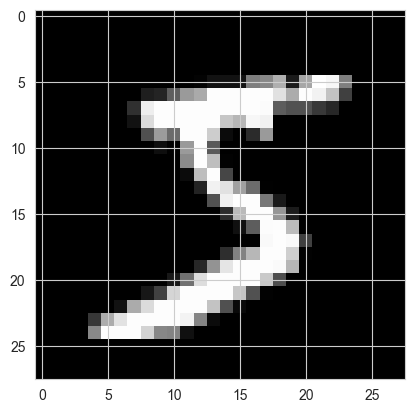

In [370]:
# Visualize a sample

label, image = trainset[0]
print(label)
plt.imshow(image.squeeze().numpy(), cmap='gray')


In [371]:
for digit, real_images in DataLoader(trainset, batch_size=64, shuffle=True):
    print(digit.shape)
    print(digit.dtype)
    print(real_images.shape)
    break

torch.Size([64])
torch.float32
torch.Size([64, 1, 28, 28])


# Train the GAN

In [372]:
_layer = nn.ConvTranspose2d(24, 1, kernel_size=16, stride=1, padding=1) # 1x1 -> 3x3
_layer2 = nn.ConvTranspose2d(1, 1, kernel_size=17, stride=1, padding=1) # 3x3 -> 9x9 # Adds 4 pixels on each side

# The layers add kernel_size - 2 - stride + 1

_inp = torch.randn(64, 24, 1, 1)

predicted_shape = (
    _inp.shape[-1]
    + _layer.kernel_size[0]
    - 2
    - _layer.stride[0]
    + _layer2.kernel_size[0]
    - 2
    - _layer2.stride[0]
)
print(predicted_shape)
_layer2(_layer(_inp)).shape


28


torch.Size([64, 1, 28, 28])

In [438]:
from datetime import datetime

class Discriminator(nn.Module):
    def __init__(self, channels_img=3, features_d=12):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(
                channels_img, features_d, kernel_size=3
            ),  # 32x32
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d, 3),  # 16x16
            self._block(features_d, features_d * 2, 3,),  # 8x8
            self._block(features_d * 2, features_d, 3),  # 4x4
            nn.Conv2d(features_d, 1, kernel_size=5),  # 1x1
            nn.MaxPool2d(3),
            nn.Flatten(),
            nn.Sigmoid(),
        )
        self.out = nn.Sequential( # This is the output layer that will take the output of the discriminator and the digit and make a decision whether the image is real or fake
            nn.Linear(50,32), # 441 + 1 for digit
            nn.LeakyReLU(0.2),
            nn.Linear(32,32), # 441 + 1 for digit
            nn.LeakyReLU(0.2),
            nn.Linear(32,1), # 441 + 1 for digit
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride=1, padding=1, bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x, digit):
        disc_out = self.disc(x)
        digit = (digit-5)/10 # Normalize the digit to be between -0.4 and 0.4
        linear = torch.cat((disc_out, digit.unsqueeze(1)), dim=1)
        return self.out(linear)


class MNISTGenerator(nn.Module):
    def __init__(self, z_dim=100, channels_img=1, features_g=64, output_dim=28, n_blocks=2):
        super(MNISTGenerator, self).__init__()
        # Input: (batch, z_dim, 1, 1)
        # Output: (batch, channels_img, output_dim, output_dim)

        remainder = (output_dim-1) % n_blocks # 28 % 3 = 1
        add_per_block = (output_dim-1) // n_blocks # 5 kernel size adds 3 
        kernel_size = 3+add_per_block # 3 blocks from 1 -> 28, need to add 28 / 3 pixels per block
        final_kernel_size = kernel_size + remainder # needs to be larger to cover the remainder
        blocks = [] # E.g. from 1 to 9 in 3 steps, 1 -> 4 (kernel size 7) -> 7 -> 9
        for i in range(n_blocks):
            if i == 0:
                blocks.append(self._block(z_dim, features_g, kernel_size, 1, 1))
            elif i < n_blocks-1:
                blocks.append(self._block(features_g, features_g, kernel_size, 1, 1))
            else:
                blocks.append(self._block(features_g, channels_img, final_kernel_size, 1, 1))

        blocks.append(nn.Tanh())
        self.gen = nn.Sequential(*blocks)

        self.z_model = nn.Sequential(
            nn.Linear(z_dim, z_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(z_dim, z_dim),
            nn.LeakyReLU(0.2),
        )
        self.digit_injector = nn.Sequential(
            nn.Linear(1, z_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(z_dim, z_dim),
            nn.LeakyReLU(0.2),
        )
        self.z_dim = z_dim

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, digit):
        # Create an input vector for the generator, sized correctly (based on z_dim)
        batch_size = digit.shape[0]

        # Create a random vector of size z_dim
        x = torch.randn(batch_size, self.z_dim)

        # Pass the random vector through the z_model
        x = self.z_model(x)
        # Add the digit to the random vector after passing it through the digit_injector
        inj_digit = self.digit_injector(digit.unsqueeze(1))
        x = (x + inj_digit) # Enabled for now
        x = x.unsqueeze(2).unsqueeze(3)
        fake_image = self.gen(x)
        return fake_image

In [439]:
generator = MNISTGenerator(z_dim=32, channels_img=1, features_g=8, output_dim=28, n_blocks=4)
discriminator = Discriminator(channels_img=1, features_d=4)

print(summary(generator, input_size=(2,), device='cpu', depth=3))
summary(discriminator,input_size=((64,1,28,28), (64,)))
# summary(gan, input_size=((64,), (64,)))

Layer (type:depth-idx)                   Output Shape              Param #
MNISTGenerator                           [2, 1, 28, 28]            --
├─Sequential: 1-1                        [2, 32]                   --
│    └─Linear: 2-1                       [2, 32]                   1,056
│    └─LeakyReLU: 2-2                    [2, 32]                   --
│    └─Linear: 2-3                       [2, 32]                   1,056
│    └─LeakyReLU: 2-4                    [2, 32]                   --
├─Sequential: 1-2                        [2, 32]                   --
│    └─Linear: 2-5                       [2, 32]                   64
│    └─LeakyReLU: 2-6                    [2, 32]                   --
│    └─Linear: 2-7                       [2, 32]                   1,056
│    └─LeakyReLU: 2-8                    [2, 32]                   --
├─Sequential: 1-3                        [2, 1, 28, 28]            --
│    └─Sequential: 2-9                   [2, 8, 7, 7]              --
│    │

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [64, 1]                   --
├─Sequential: 1-1                        [64, 49]                  --
│    └─Conv2d: 2-1                       [64, 4, 26, 26]           40
│    └─LeakyReLU: 2-2                    [64, 4, 26, 26]           --
│    └─Sequential: 2-3                   [64, 4, 26, 26]           --
│    │    └─Conv2d: 3-1                  [64, 4, 26, 26]           144
│    │    └─BatchNorm2d: 3-2             [64, 4, 26, 26]           8
│    │    └─LeakyReLU: 3-3               [64, 4, 26, 26]           --
│    └─Sequential: 2-4                   [64, 8, 26, 26]           --
│    │    └─Conv2d: 3-4                  [64, 8, 26, 26]           288
│    │    └─BatchNorm2d: 3-5             [64, 8, 26, 26]           16
│    │    └─LeakyReLU: 3-6               [64, 8, 26, 26]           --
│    └─Sequential: 2-5                   [64, 4, 26, 26]           --
│    │    └─Co

In [440]:
# Create a GAN class that takes in the generator and discriminator, and the training data
# The GAN class will be responsible for training the generator and discriminator
# The GAN should train the generator to generate images of the digit that is fed as the input

class GAN(nn.Module):
    def __init__(self, generator, discriminator, trainset, testset, device='cpu', batch_size=32):
        super(GAN, self).__init__()
        self.trainset = trainset
        self.testset = testset
        self.device = device
        self.batch_size = batch_size

        self.generator = generator.to(device)
        self.discriminator = discriminator.to(device)
        self.criterion = nn.BCELoss()
        self.d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=0.002)
        self.g_optimizer = torch.optim.Adam(self.generator.parameters(), lr=0.0002)

    def train_n_epochs(self, epochs, batch_size=32):
        print(f'Starting...\nTime: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
        for epoch in range(epochs):
            self._train_epoch(epoch, batch_size=batch_size)

    def forward(self, digit):
        return self.generate(digit)

    def _train_epoch(self, epoch, batch_size=32):
        self.generator.train()
        self.discriminator.train()

        mean_loss_d = 0
        mean_loss_g = 0


        for digits, real_images in DataLoader(self.trainset, batch_size=batch_size, shuffle=True):
   
            real_images = real_images.to(self.device)
            digits = digits.to(self.device)

            real_labels = torch.ones(real_images.size(0), 1).to(self.device)
            fake_labels = torch.zeros(real_images.size(0), 1).to(self.device)

            # Train the discriminator
            self.d_optimizer.zero_grad()

            real_outputs = self.discriminator(real_images, digits.to(self.device))
            # print(real_outputs.shape, real_labels.shape)
            d_loss_real = self.criterion(real_outputs, real_labels)
            d_loss_real.backward()

            fake_images = self.generator(digits)
            fake_outputs = self.discriminator(fake_images, digits)
            d_loss_fake = self.criterion(fake_outputs, fake_labels)
            d_loss_fake.backward()

            d_loss = d_loss_real + d_loss_fake

            self.d_optimizer.step()

            # Train the generator
            self.g_optimizer.zero_grad()

            fake_images = self.generator(digits)
            fake_outputs = self.discriminator(fake_images, digits)
            g_loss = self.criterion(fake_outputs, real_labels) # We want the generator to generate images that the discriminator thinks are real
            g_loss.backward()

            self.g_optimizer.step()

            mean_loss_d += d_loss.item()
            mean_loss_g += g_loss.item()


        print(f'Time: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")},Epoch {epoch}, D loss: {d_loss.item()}, G loss: {g_loss.item()}')

        mean_loss_d /= len(self.trainset)
        mean_loss_g /= len(self.trainset)

        return mean_loss_d, mean_loss_g

    def generate(self, digit):
        self.generator.eval()
        return self.generator(digit.to(self.device)).detach().cpu()


In [441]:
gan = GAN(generator, discriminator, trainset, testset, device='cpu')
# Train the GAN
# gan.train_n_epochs(1, 32)

In [442]:
gan.train_n_epochs(10, 64)


Starting...
Time: 2024-05-10 18:18:06
Time: 2024-05-10 18:19:31,Epoch 0, D loss: 100.0, G loss: 0.0
Time: 2024-05-10 18:20:57,Epoch 1, D loss: 100.0, G loss: 0.0


KeyboardInterrupt: 

In [396]:
# Train the GAN

gan.train_n_epochs(10, 32)

Time: 2024-05-10 17:55:33,Epoch 0, D loss: 1.9694897446242976e-07, G loss: 15.510581970214844
Time: 2024-05-10 17:57:20,Epoch 1, D loss: 4.4035989077428894e-08, G loss: 17.131580352783203


KeyboardInterrupt: 

In [ ]:
# Train the GAN

gan.train_n_epochs(10, 64)

Time: 2024-05-04 23:15:55,Epoch 0, D loss: 1.2664172649383545, G loss: 0.7814494371414185
Time: 2024-05-04 23:18:12,Epoch 2, D loss: 1.6521220207214355, G loss: 0.9710193276405334
Time: 2024-05-04 23:20:30,Epoch 4, D loss: 0.8520565629005432, G loss: 1.512847900390625
Time: 2024-05-04 23:22:46,Epoch 6, D loss: 1.3171820640563965, G loss: 0.9108135104179382
Time: 2024-05-04 23:25:03,Epoch 8, D loss: 0.9192835688591003, G loss: 1.4069147109985352


In [ ]:
(9-5)/10

0.4

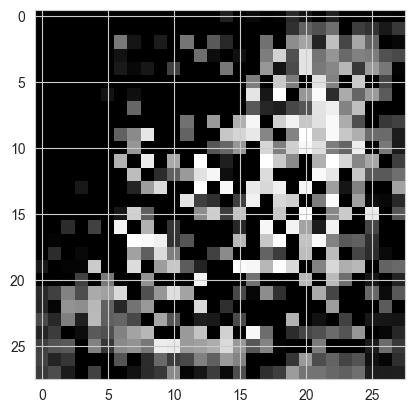

In [443]:
# Demo the GAN

digit = torch.tensor([5.0])

fake_images = gan(digit)

plt.imshow(fake_images[0].squeeze().detach().numpy(), cmap='gray')